In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [34]:
paths = ["BSRN-PAY.nc", "BSRN-BAR.nc", "BSRN-BOU.nc", "BSRN-TAT.nc", "BSRN-CAR.nc"]
times_begin = [
    np.datetime64("1998-01-01"),
    np.datetime64("2003-01-01"),
    np.datetime64("1999-01-01"),
    np.datetime64("1998-01-01"),
    np.datetime64("1998-01-01")
]
times_end = [
    np.datetime64("2011-01-01"),
    np.datetime64("2017-01-01"),
    np.datetime64("2012-01-02"),
    np.datetime64("2023-01-01"),
    np.datetime64("2010-01-01")
]

In [35]:
PLOTTED_PERIODS = [2, 4, 8, 16, 32, 64, 128, 256, 512]

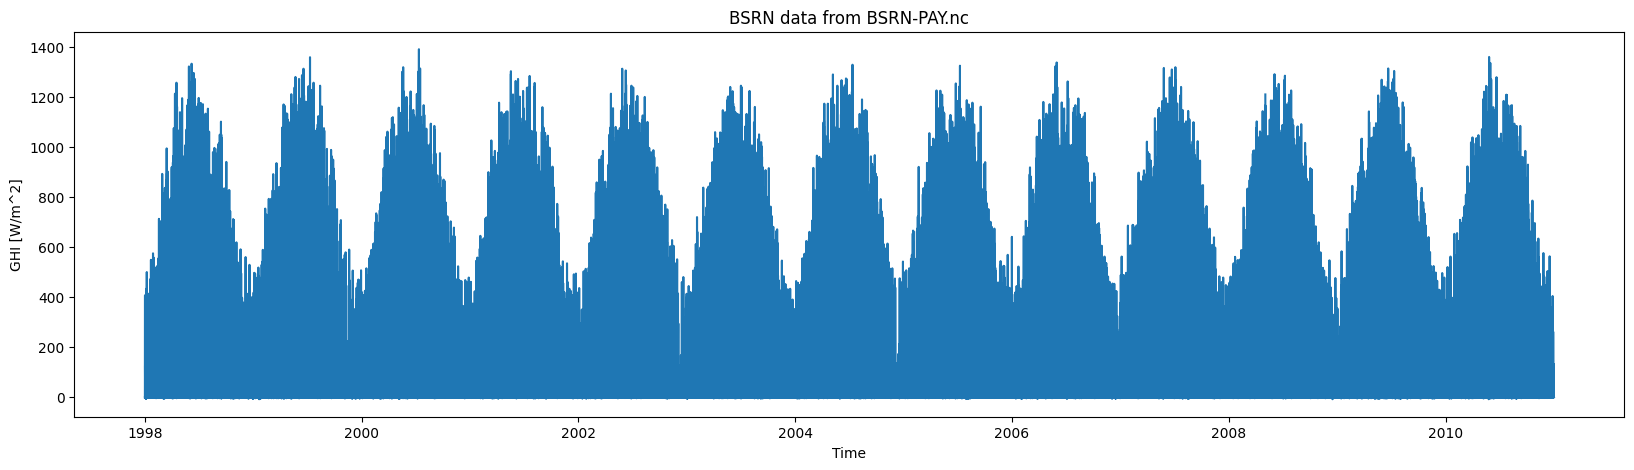

Start: 1998-01-12T12:30:00.000000000
End: 1998-01-12T12:31:00.000000000
Start: 2010-12-08T21:30:00.000000000
End: 2010-12-09T08:15:00.000000000
Longest consecutive missing data: 81 hours
Longest consecutive missing data: 3 days
Start: 2001-12-07T00:00:00.000000000
End: 2001-12-10T09:24:00.000000000


In [36]:
# Load the data
i_path = 0 
ds = xr.open_dataset(paths[i_path])
ds = ds.sel(time=slice(times_begin[i_path], times_end[i_path]))

# Plot the data
fig, ax = plt.subplots()
# Change figure size
fig.set_size_inches(20, 5)
ds["GHI"].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.set_title("BSRN data from " + paths[i_path])
plt.show()

# Compute the longest consecutive missing data
missing_data = ds["GHI"].isnull()
missing_data = missing_data.astype(int).diff(dim="time")
# Calculate length of consecutive missing data
missing_data_start = missing_data.where(missing_data == 1, drop=True)
missing_data_end = missing_data.where(missing_data == -1, drop=True)
# Print the start and end first timesteps
print("Start: " + str(missing_data_start["time"].values[0]))
print("End: " + str(missing_data_end["time"].values[0]))
# Print the start and end last timesteps
print("Start: " + str(missing_data_start["time"].values[-1]))
print("End: " + str(missing_data_end["time"].values[-1]))
missing_data = missing_data_end["time"].values - missing_data_start["time"].values
# Calculate the longest consecutive missing data
missing_data_hours = missing_data.max().astype("timedelta64[h]").astype(int)
missing_data_days = missing_data.max().astype("timedelta64[D]").astype(int)

index_longest = missing_data.argmax()

# Print the longest consecutive missing data
print("Longest consecutive missing data: " + str(missing_data_hours) + " hours")
print("Longest consecutive missing data: " + str(missing_data_days) + " days")
print("Start: " + str(missing_data_start["time"].values[index_longest]))
print("End: " + str(missing_data_end["time"].values[index_longest]))


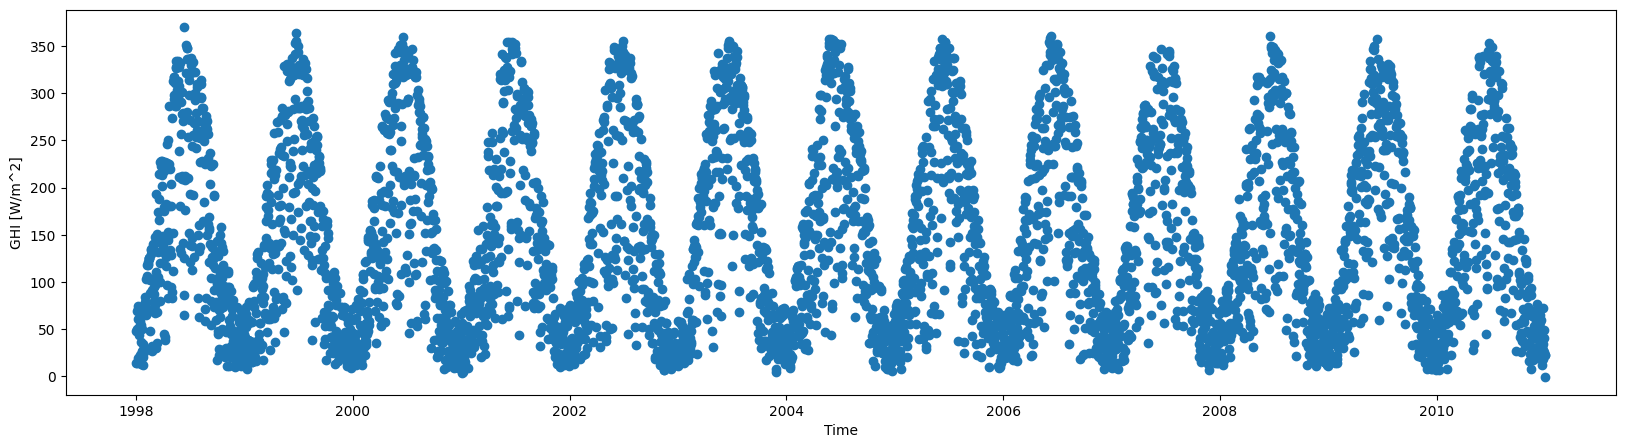

In [40]:
# Calculate the dataframe resampled
ds_resampled = ds["GHI"].resample(time="24H").reduce(
    lambda x, axis: np.nanmean(x) if np.isnan(x).sum() < 0.2 * len(x) else np.nan
)
# Interpolate the missing values
ds_resampled = ds_resampled.interpolate_na(dim="time", method="linear")

# Plot the data
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ds_resampled.plot(ax=ax, marker="o", linestyle="None")
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
# ax.set_title("BSRN data from " + paths[i_path])
ax.set_title("")
plt.show()

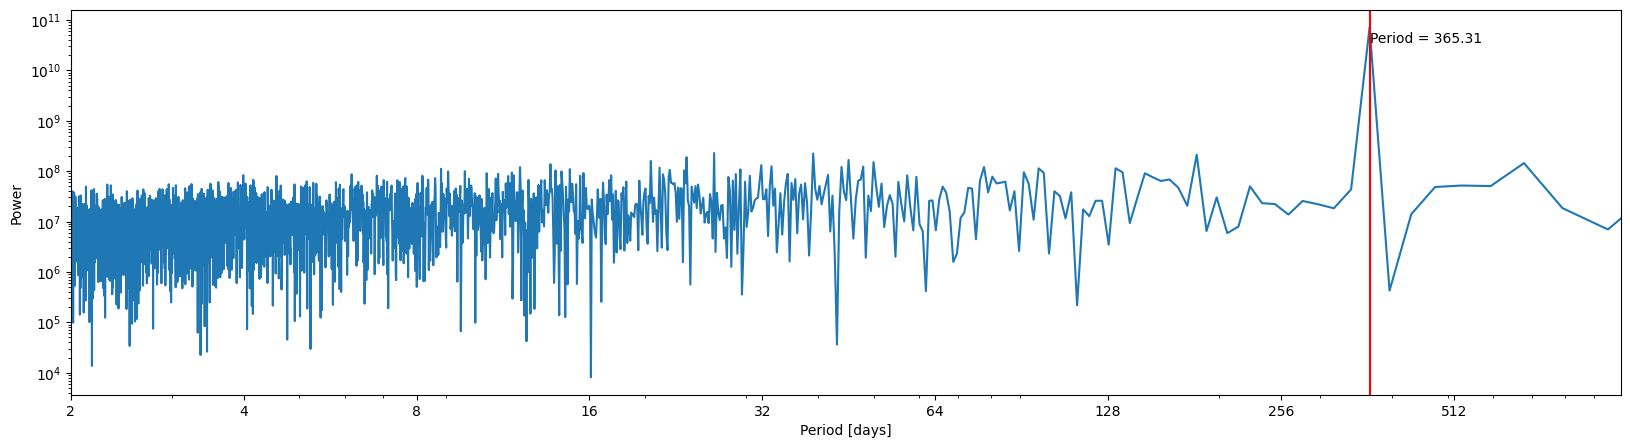

In [41]:
# Përform data analysis diagnostics
df_resampled = ds_resampled.to_dataframe()[["GHI"]]

# 1. FFT
# Calculate the FFT
fft = np.fft.fft(df_resampled["GHI"])
fft = fft[1 : len(fft) // 2]
# Calculate the power spectrum
power_spectrum = np.abs(fft) ** 2
# Calculate the frequencies
sample_freq = np.fft.fftfreq(len(df_resampled["GHI"]), d=1)
sample_freq = sample_freq[1 : len(sample_freq) // 2]
# Plot the power spectrum as a function of the period
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(1 / sample_freq, power_spectrum)
# Plot the highest peak in the power spectrum as a vertical line
max_period = 1 / sample_freq[np.argmax(power_spectrum)]
ax.axvline(max_period, color="red")
# Add text to this line
ax.text(
    max_period,
    0.5 * np.max(power_spectrum),
    "Period = " + str(np.round(max_period, 2))
)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_xlim(2, 1000)
plt.show()


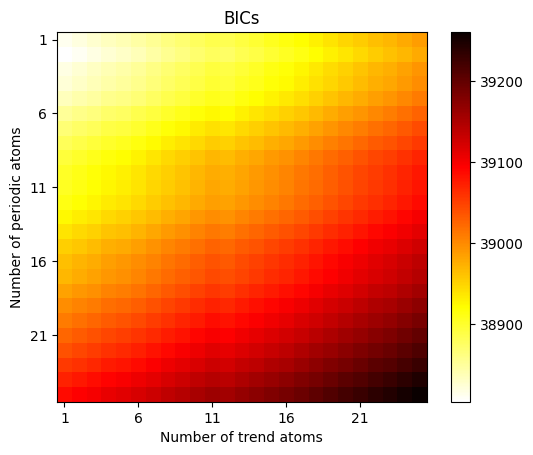

Preferred number of trend atoms: 1
Preferred number of periodic atoms: 2


In [42]:
# Extract trend (mean) and seasonality (periodic component)
def generate_trend_atoms(k, length):
    """Generate trend atoms of given length."""
    atoms = np.zeros((k, length))
    for i in range(k):
        atoms[i, :] = np.linspace(0, 1, length) ** i
    return atoms

def generate_periodic_atoms(periods, length):
    """Generate periodic atoms of given periods and length."""
    atoms = np.zeros((2 * len(periods), length))
    for i, period in enumerate(periods):
        atoms[i, :] = np.sin(np.arange(length) * 2 * np.pi / period)
        atoms[i + len(periods), :] = np.cos(np.arange(length) * 2 * np.pi / period)
    return atoms

# extract trend (mean) and seasonality (periodic component) using least squares
BICs = np.zeros((25, 25))
for i in range(1, 26):
    for j in range(1, 26):
        nb_periods = i
        periods = [max_period / p for p in np.arange(1, nb_periods + 1)]
        periodic_atoms = generate_periodic_atoms(periods, len(df_resampled["GHI"]))
        nb_trend_atoms = j
        trend_atoms = generate_trend_atoms(nb_trend_atoms, len(df_resampled["GHI"]))
        atoms = np.concatenate((periodic_atoms, trend_atoms), axis=0)

        # Calculate the least squares solution
        solution = np.linalg.lstsq(atoms.T, df_resampled["GHI"], rcond=None)[0]

        # Calculate the residuals
        residuals = df_resampled["GHI"] - np.dot(atoms.T, solution)

        # Calculate the likelihood
        likelihood = -0.5 * len(residuals) * np.log(np.sum(residuals**2 / len(residuals)))

        # Calculate the number of parameters (k) in your model
        k = len(solution)

        # Calculate BIC
        n = len(df_resampled["GHI"])
        bic = -2 * likelihood + k * np.log(n)
        BICs[i - 1, j - 1] = bic

# Plot the BICs
plt.imshow(BICs, cmap="hot_r")
plt.colorbar()
plt.xlabel("Number of trend atoms")
plt.ylabel("Number of periodic atoms")
plt.xticks(np.arange(0, 25, 5), np.arange(1, 26, 5))
plt.yticks(np.arange(0, 25, 5), np.arange(1, 26, 5))
plt.title("BICs")
plt.show()

argmin_BICs = np.argmin(BICs)
nb_periods, nb_trend_atoms = np.unravel_index(argmin_BICs, BICs.shape)
nb_periods += 1
nb_trend_atoms += 1
        
print("Preferred number of trend atoms: " + str(nb_trend_atoms))
print("Preferred number of periodic atoms: " + str(nb_periods))

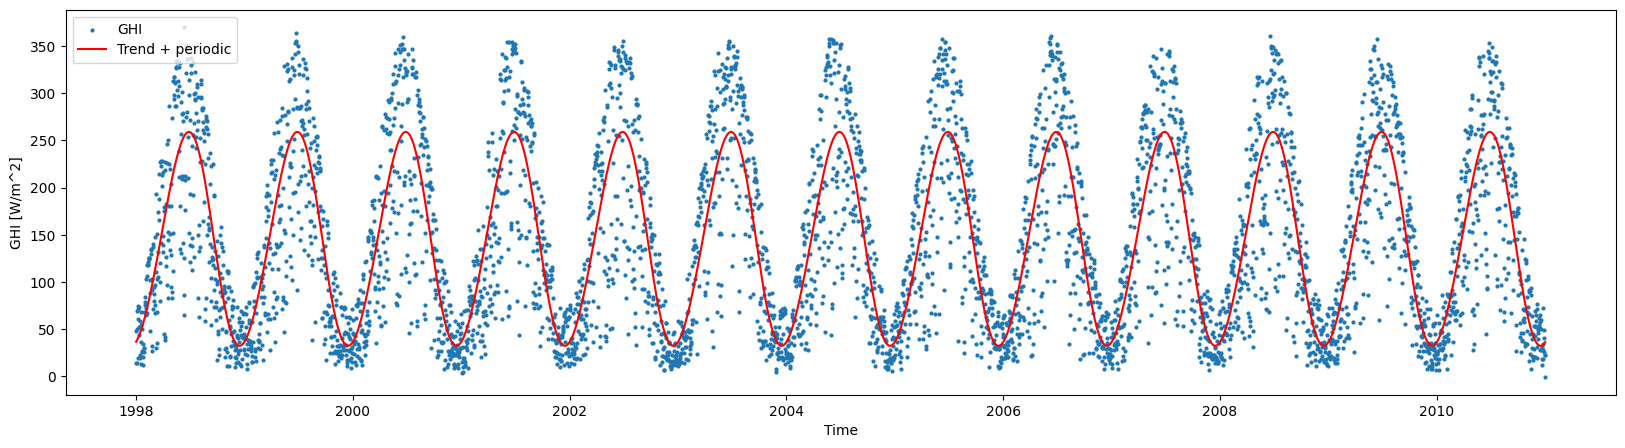

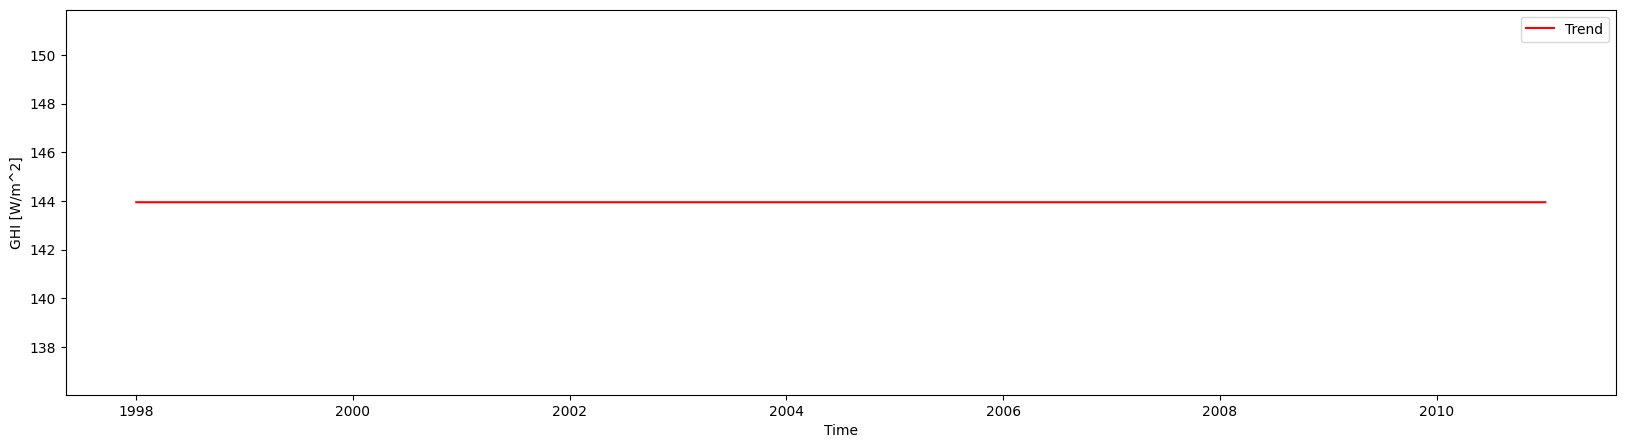

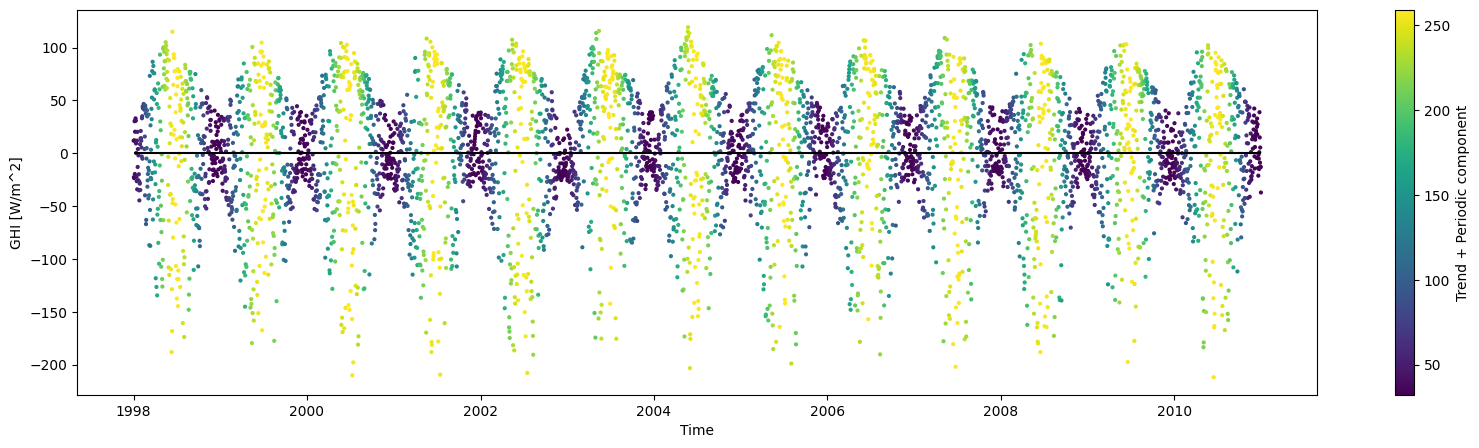

In [43]:

periods = [max_period / p for p in np.arange(1, nb_periods + 1)]
periodic_atoms = generate_periodic_atoms(periods, len(df_resampled["GHI"]))
trend_atoms = generate_trend_atoms(nb_trend_atoms, len(df_resampled["GHI"]))
atoms = np.concatenate((periodic_atoms, trend_atoms), axis=0)

# Calculate the least squares solution
solution = np.linalg.lstsq(atoms.T, df_resampled["GHI"], rcond=None)[0]

# Plot the trend and periodic components
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.scatter(df_resampled.index, df_resampled["GHI"], label="GHI", s=4)
ax.plot(df_resampled.index, np.dot(atoms.T, solution), label="Trend + periodic", color="red")
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.legend()
plt.show()

# Plot the trend
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(df_resampled.index, np.dot(trend_atoms.T, solution[nb_periods * 2:]), label="Trend", color="red")
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(20, 5))
plt.scatter(df_resampled.index, df_resampled["GHI"] - np.dot(atoms.T, solution), c=np.dot(atoms.T, solution), s=4)
plt.hlines(0, df_resampled.index[0], df_resampled.index[-1], color="black")
plt.colorbar(label="Trend + Periodic component")
plt.xlabel("Time")
plt.ylabel("GHI [W/m^2]")
plt.show()

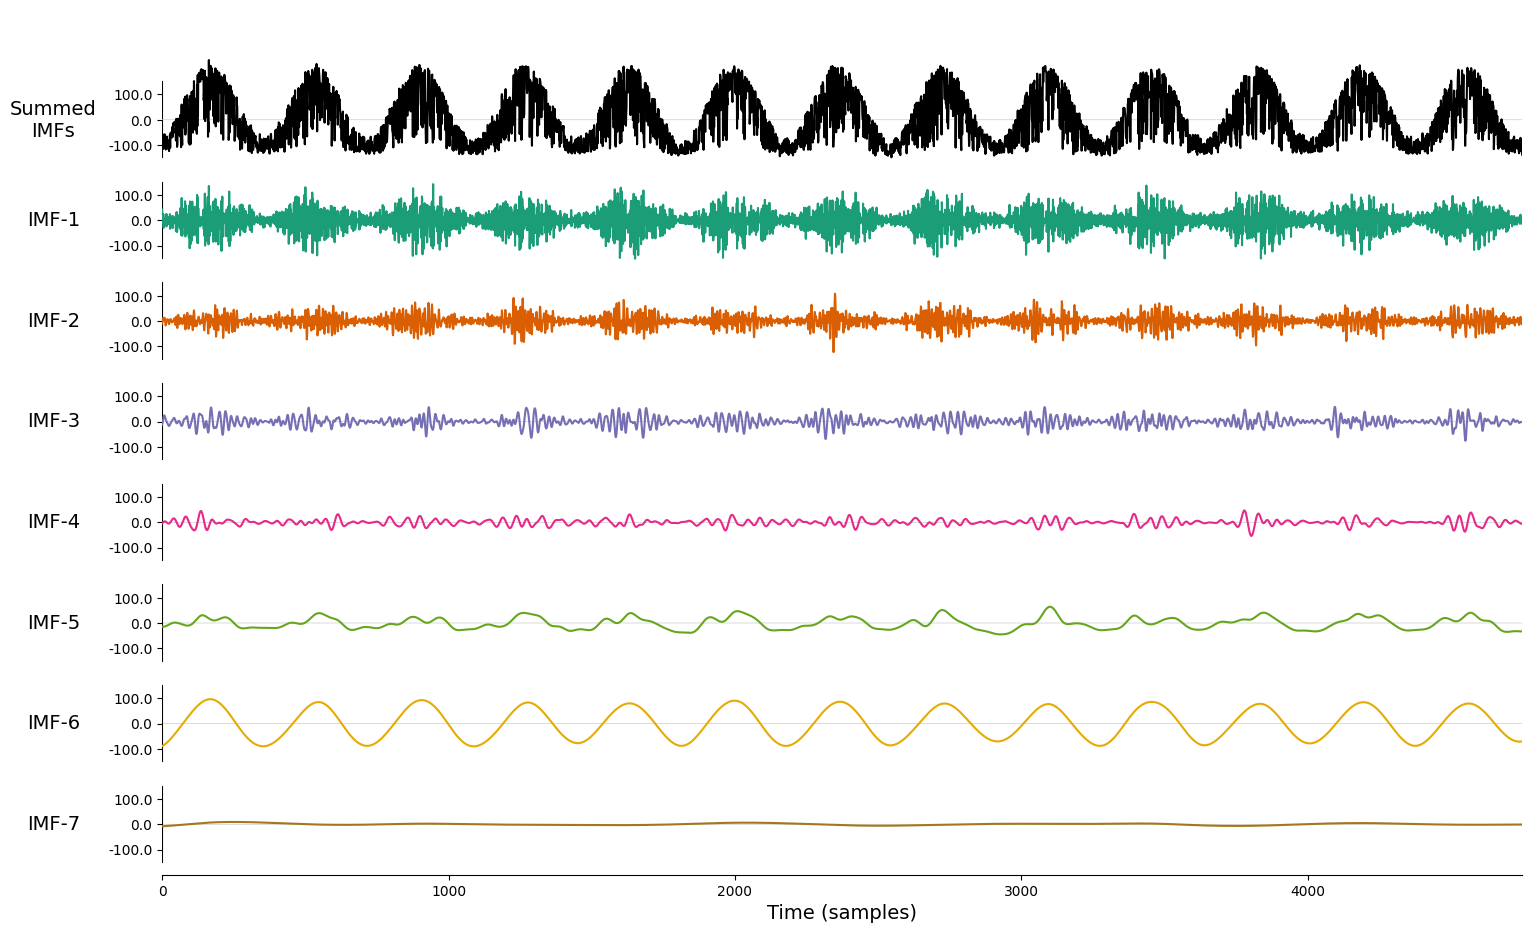

In [59]:
import emd

# Calculate the EMD
imf = emd.sift.ensemble_sift(ds_resampled.values, max_imfs=7, nensembles=1024, nprocesses=32, ensemble_noise=1)
emd.plotting.plot_imfs(imf)

IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')

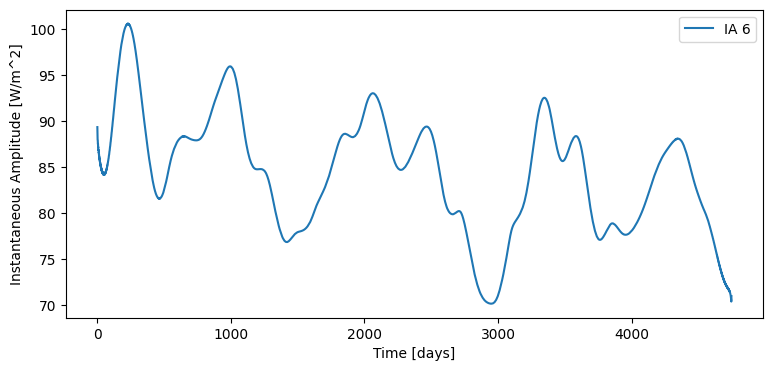

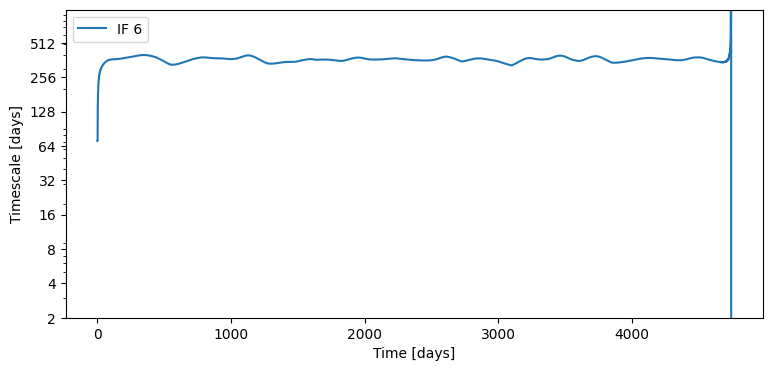

In [63]:
# Plot IA k+1 and IF k+1
k = 5
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(IA[:, k], label="IA 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Instantaneous Amplitude [W/m^2]")
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(1 / IF[:, k], label="IF 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Timescale [days]")
ax.set_yscale("log")
ax.set_yticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_ylim(2, 1000)
ax.legend()
plt.show()


c:\Users\Marius\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 100000 is greater than input length  = 4749, using nperseg = 4749
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Marius\AppData\Local\Temp\ipykernel_18656\685190708.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
C:\Users\Marius\AppData\Local\Temp\ipykernel_18656\685190708.py:17: RuntimeWarning: divide by zero encountered in divide
  T = 1/f[::-1]


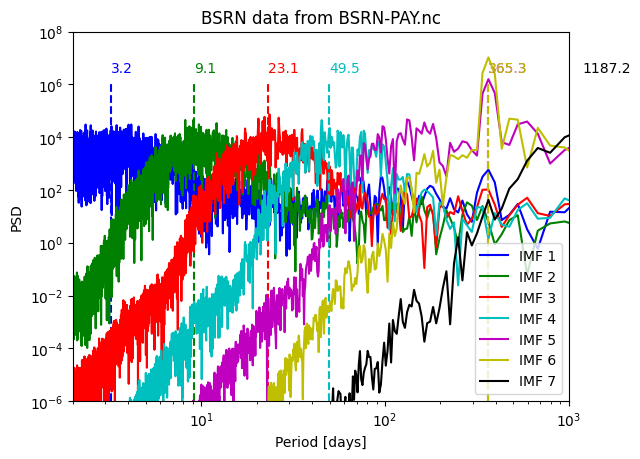

In [45]:
# Compute PSDs of the IMFs
from scipy import signal
from itertools import cycle

f, Pxx = signal.welch(imf.T, fs=1, nperseg=100000)

COLORS = cycle(["b", "g", "r", "c", "m", "y", "k"])

# Plot the PSDs (x axis is period in days)
fig, ax = plt.subplots()
for i in range(imf.shape[1]):
    color = next(COLORS)
    ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
    # Plot the median of the PSD for each IMF (vline)
    cumsum_T = np.cumsum(Pxx[i, ::-1])
    cumsum_T /= cumsum_T[-1]
    T = 1/f[::-1]
    T = T[cumsum_T > 0.5][0]
    ax.vlines(T, 1e-6, 1e6, color=color, linestyle="--")
    # add text
    ax.text(T, 3e6, "%.1f" % T, color=color)
ax.legend()
ax.set_xlabel("Period [days]")
ax.set_ylabel("PSD")
ax.set_title("BSRN data from " + paths[i_path])
ax.set_xscale("log")
ax.set_yscale("log")
# limit the y axis
ax.set_ylim(1e-6, 1e8)
ax.set_xlim(2, 1000)
plt.show()

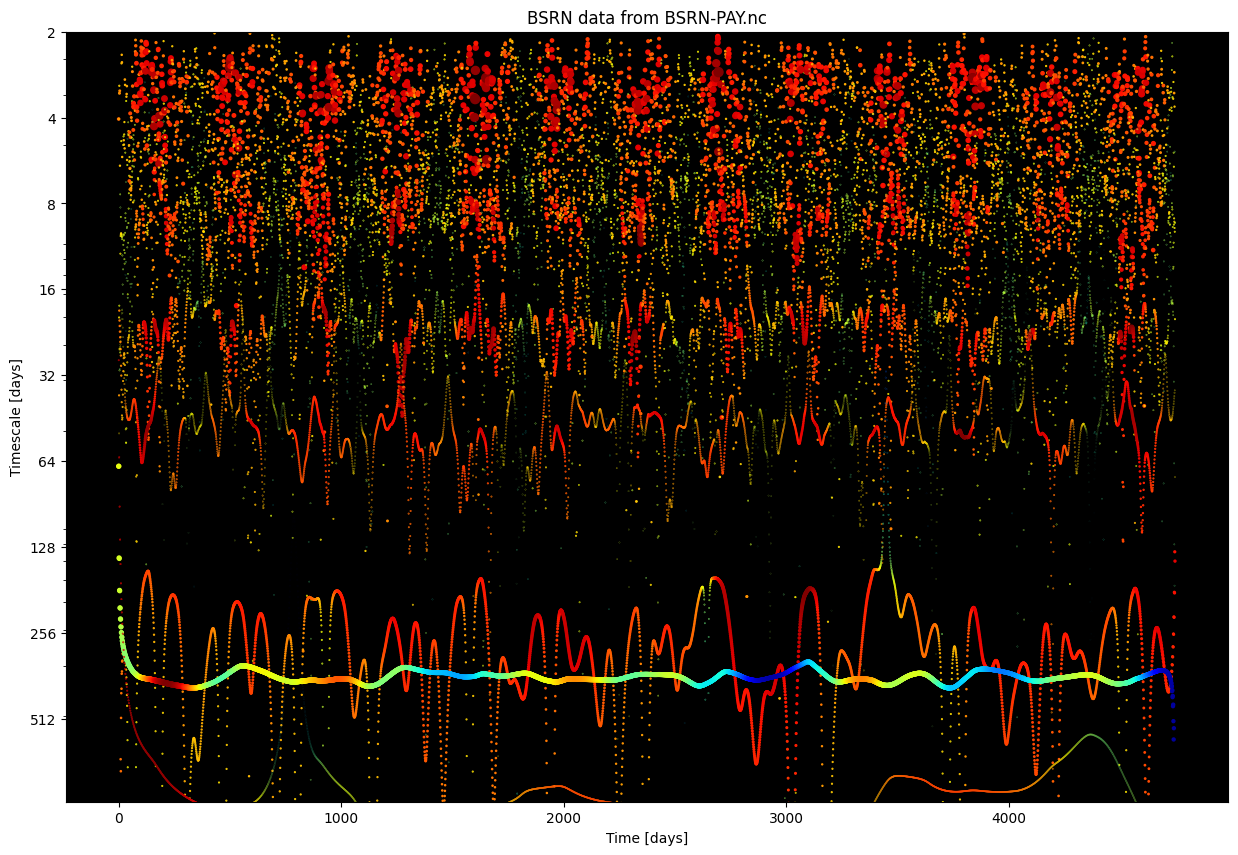

In [46]:
plt.figure(figsize=(15, 10))
# Set background color
plt.rcParams['axes.facecolor'] = "k"
for i in range(imf.shape[1]):
    plt.scatter(np.arange(len(imf)), IF[:, i], c=np.log(IA[:, i]), cmap="jet", s=0.001*IA[:, i]**2, label="IMF %d" % (i +1))
plt.xlabel("Time [days]")
plt.ylabel("Timescale [days]")
plt.title("BSRN data from " + paths[i_path])
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.show()

plt.rcParams['axes.facecolor'] = "w"


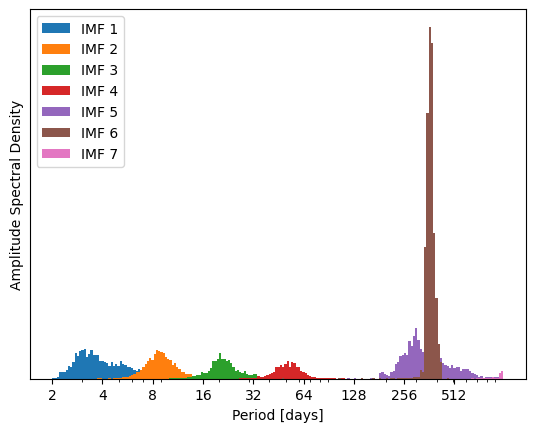

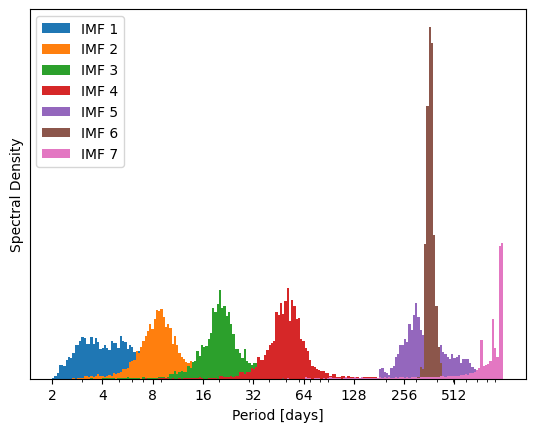

In [32]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')

f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
f, hht_0a = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)

# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Amplitude Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()


# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht_0a[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()

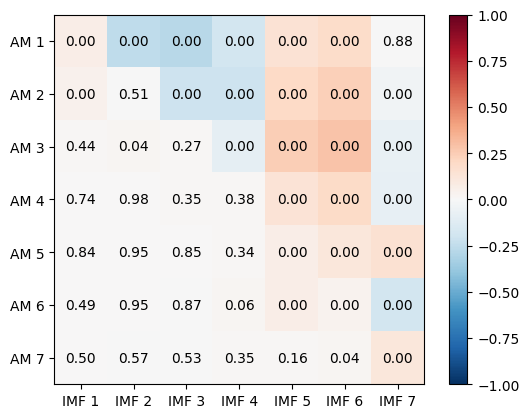

In [33]:
# Compute Kendall's taucorrelation matrix between IA and IMFs
from scipy.stats import kendalltau

taus = np.zeros((imf.shape[1], imf.shape[1]))
ps = np.zeros((imf.shape[1], imf.shape[1]))
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        tau, p = kendalltau(IA[:, i], imf[:, j])
        taus[i, j] = tau
        ps[i, j] = p

# Plot the correlation matrix as a heatmap (p values are written in the cells)
plt.imshow(taus, cmap="RdBu_r", vmin=-1, vmax=1)
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        plt.text(j, i, "%.2f" % ps[i, j], ha="center", va="center")
plt.xticks(np.arange(imf.shape[1]), ["IMF %d" % (i + 1) for i in range(imf.shape[1])])
plt.yticks(np.arange(imf.shape[1]), ["AM %d" % (i + 1) for i in range(imf.shape[1])])
plt.colorbar()
plt.show()

In [22]:
resample_rates = np.arange(24, 48, 2)
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')
SWMFs = np.zeros((len(resample_rates), 7))
for i_rr, rr in enumerate(resample_rates):
    freq_ratio = 24 / rr
    ds_resampled = ds["GHI"].resample(time="{}H".format(rr)).reduce(
        lambda x, axis: np.nanmean(x) if np.isnan(x).sum() < 0.2 * len(x) else np.nan
    )
    ds_resampled = ds_resampled.interpolate_na(dim="time", method="linear")
    print(len(ds_resampled))
    imf = emd.sift.ensemble_sift(ds_resampled.values, max_imfs=7, nensembles=1024, nprocesses=32, ensemble_noise=4)
    IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
    SWMFs[i_rr, :] = freq_ratio * np.sum(hht * f[:, None], axis=0) / np.sum(hht, axis=0)

4749
4383
4070
3799
3562
3352
3166
2999
2849
2714
2590
2478


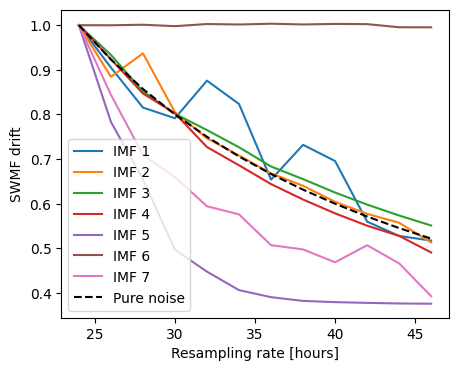

In [270]:
# Plot the SWMFs
plt.figure(figsize=(5, 4))
for i in range(imf.shape[1]):
    plt.plot(resample_rates, SWMFs[:, i] / SWMFs[0, i], label="IMF %d" % (i +1))
# Plot the behaviour of the SWMF for a pure noise signal
plt.plot(resample_rates, 24 / resample_rates, color="black", linestyle="--", label="Pure noise")
plt.xlabel("Resampling rate [hours]")
plt.ylabel("SWMF drift")
# plt.title("BSRN data from " + paths[i_path])
plt.legend()
plt.show()